# Двухуровневые модели рекомендаций

**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [2]:
data = pd.read_csv('./data/retail_train.csv')
item_features = pd.read_csv('./data/product.csv')
user_features = pd.read_csv('./data/hh_demographic.csv')

ITEM_COL = 'item_id'
USER_COL = 'user_id'

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)

VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [3]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [4]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [5]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [6]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\Users\Илья\Desktop\GeekBrains\Рекомендательные системы\webinar_6\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [7]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


**Я изменил fit в MainRecommender на оптимальные параметры ALS, найденные в прошлых уроках**

In [8]:
recommender = MainRecommender(data_train_matcher)

In [9]:
ACTUAL_COL = 'actual'

result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [10]:
N_PREDICT = 50 

In [11]:
%%time
# для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=50))

Wall time: 33min 21s


In [12]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [13]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [14]:
TOPK_RECALL = 50

In [15]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.09731601791843496),
 ('als_rec', 0.06586307980507604),
 ('sim_item_rec', 0.03893042711754625)]

In [16]:
TOPK_PRECISION = 5

In [17]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.3237563923756395),
 ('als_rec', 0.16968851696884926),
 ('sim_item_rec', 0.06861924686192487)]

Как видно, наибольший recall@k дает own recommendations + top-popular. Так происходит из-за особенностей решаемой задачи - в крупном ритейле пользователи с определенной периодичностью берут похожие товары.

Теперь построим зависисмость recall@k от k для own_recommendations

In [18]:
%%time

result_eval_matcher['own_rec_500'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=500))

Wall time: 16min 6s


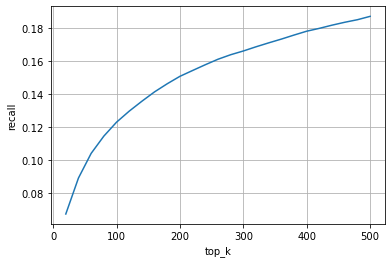

In [19]:
top_k_list = np.arange(20, 520, 20)
recall_list = []
for top_k in top_k_list:
    recall_list.append(result_eval_matcher.apply(lambda row: recall_at_k(row['own_rec_500'], row[ACTUAL_COL], k=top_k), axis=1).mean())

plt.plot(top_k_list, recall_list)
plt.xlabel('top_k')
plt.ylabel('recall')
plt.grid()
plt.show()

Кореляция recall от k похожа на логарифмическую. При выборе k нужно найти баланс между значением recall и объемом обучающего бустинг датасета, оптимальным кажется 200.

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах


## Подготовка данных для трейна

In [83]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [84]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1029743, 913210, 1016800, 933067, 838186, 926..."
1,2021,"[950935, 1119454, 844179, 1044078, 6534077, 10..."


In [85]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [86]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1029743
0,2070,913210
0,2070,1016800
0,2070,933067


### Check warm start

In [87]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (107550, 2) Users: 2151 Items: 4879


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [89]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 
df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


#### Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей

In [90]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

df_ranker_train.target.value_counts()

0.0    94019
1.0    12725
Name: target, dtype: int64

## Подготавливаем фичи для обучения модели

In [91]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [92]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [93]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,913210,1.0,2,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,405.6 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


### Фичи user_id

**Найдем средний чек для каждого юзера (average order value)**

basket_id - это, видимо, один сеанс покупок пользователя. Сгруппировав по этому признаку, найдем стоимость каждой корзины, а далее найдем AOV

In [94]:
data_train_ranker.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


In [95]:
aov_df = data_train_ranker.groupby(['user_id', 'basket_id'], as_index=False).agg({'sales_value': 'sum'}).rename(columns={'sales_value': 'order_value'})
aov_df = aov_df.groupby(['user_id'], as_index=False).agg({'order_value': 'mean'}).rename(columns={'order_value': 'aov'})
aov_df.head(2)

,user_id,aov
0,1,48.825714
1,2,47.572500


In [96]:
aov_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2151 entries, 0 to 2150
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  2151 non-null   int64  
 1   aov      2151 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.4 KB


In [97]:
df_ranker_train.user_id.nunique()

2151

**Средняя сумма покупки 1 товара в каждой категории**

In [98]:
aov_one_item_by_category = data_train_ranker.copy()
aov_one_item_by_category = aov_one_item_by_category.merge(item_features[['item_id','department']], on='item_id', how='left')
aov_one_item_by_category = aov_one_item_by_category.groupby(['user_id', 'department'], as_index=False).agg({'quantity': 'sum', 'sales_value': 'sum'})
aov_one_item_by_category['aov_one_item_by_category'] = aov_one_item_by_category.sales_value / aov_one_item_by_category.quantity
aov_one_item_by_category = pd.pivot_table(aov_one_item_by_category,
                                          index='user_id',
                                          columns='department',
                                          values='aov_one_item_by_category',
                                          aggfunc='sum',
                                          fill_value=0,
                                          )
aov_one_item_by_category.head(2)

department,,AUTOMOTIVE,CHEF SHOPPE,CNTRL/STORE SUP,COSMETICS,COUP/STR & MFG,DELI,DELI/SNACK BAR,DRUG GM,FLORAL,...,PHOTO,PRODUCE,RESTAURANT,RX,SALAD BAR,SEAFOOD,SEAFOOD-PCKGD,SPIRITS,TRAVEL & LEISUR,VIDEO
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,0.0,0,0.0,0.0,2.4375,0.0,4.143846,0.0,...,0.0,1.067143,0.0,0.0,3.71,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0,0.0,0.0,0.0000,0.0,3.645556,0.0,...,0.0,1.810000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


In [99]:
aov_one_item_by_category.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2151 entries, 1 to 2500
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0                    2151 non-null   int64  
 1   AUTOMOTIVE       2151 non-null   float64
 2   CHEF SHOPPE      2151 non-null   float64
 3   CNTRL/STORE SUP  2151 non-null   int64  
 4   COSMETICS        2151 non-null   float64
 5   COUP/STR & MFG   2151 non-null   float64
 6   DELI             2151 non-null   float64
 7   DELI/SNACK BAR   2151 non-null   float64
 8   DRUG GM          2151 non-null   float64
 9   FLORAL           2151 non-null   float64
 10  FROZEN GROCERY   2151 non-null   float64
 11  GARDEN CENTER    2151 non-null   float64
 12  GM MERCH EXP     2151 non-null   float64
 13  GROCERY          2151 non-null   float64
 14  KIOSK-GAS        2151 non-null   float64
 15  MEAT             2151 non-null   float64
 16  MEAT-PCKGD       2151 non-null   float64
 17  MISC SALES TRA

**Кол-во покупок в каждой категории**

In [100]:
q_purchase_by_department = data_train_ranker.copy()
q_purchase_by_department = q_purchase_by_department.merge(item_features[['item_id','department']], on='item_id', how='left')
q_purchase_by_department = q_purchase_by_department.groupby(['user_id', 'department'], as_index=False).agg({'quantity': 'sum'}).rename(columns={'quantity': 'q_purchase_by_department'})
q_purchase_by_department = pd.pivot_table(q_purchase_by_department,
                                          index='user_id',
                                          columns='department',
                                          values='q_purchase_by_department',
                                          aggfunc='sum',
                                          fill_value=0,
                                          )
for col in q_purchase_by_department.columns.tolist():
    new_col = 'qpbd_' + col
    q_purchase_by_department.rename(columns={col: new_col}, inplace=True)
q_purchase_by_department.head(4)

department,qpbd_,qpbd_AUTOMOTIVE,qpbd_CHEF SHOPPE,qpbd_CNTRL/STORE SUP,qpbd_COSMETICS,qpbd_COUP/STR & MFG,qpbd_DELI,qpbd_DELI/SNACK BAR,qpbd_DRUG GM,qpbd_FLORAL,...,qpbd_PHOTO,qpbd_PRODUCE,qpbd_RESTAURANT,qpbd_RX,qpbd_SALAD BAR,qpbd_SEAFOOD,qpbd_SEAFOOD-PCKGD,qpbd_SPIRITS,qpbd_TRAVEL & LEISUR,qpbd_VIDEO
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,4,0,13,0,...,0,14,0,0,3,0,0,0,0,0
2,0,0,0,0,0,0,0,0,9,0,...,0,6,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,2,0,5,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,24,0,...,0,38,0,0,0,0,1,0,0,0


In [101]:
q_purchase_by_department.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2151 entries, 1 to 2500
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   qpbd_                 2151 non-null   int64
 1   qpbd_AUTOMOTIVE       2151 non-null   int64
 2   qpbd_CHEF SHOPPE      2151 non-null   int64
 3   qpbd_CNTRL/STORE SUP  2151 non-null   int64
 4   qpbd_COSMETICS        2151 non-null   int64
 5   qpbd_COUP/STR & MFG   2151 non-null   int64
 6   qpbd_DELI             2151 non-null   int64
 7   qpbd_DELI/SNACK BAR   2151 non-null   int64
 8   qpbd_DRUG GM          2151 non-null   int64
 9   qpbd_FLORAL           2151 non-null   int64
 10  qpbd_FROZEN GROCERY   2151 non-null   int64
 11  qpbd_GARDEN CENTER    2151 non-null   int64
 12  qpbd_GM MERCH EXP     2151 non-null   int64
 13  qpbd_GROCERY          2151 non-null   int64
 14  qpbd_KIOSK-GAS        2151 non-null   int64
 15  qpbd_MEAT             2151 non-null   int64
 16  qpbd_M

**Частотность покупок раз/неделя**

In [102]:
time_interval = data_train_ranker['week_no'].max() - data_train_ranker['week_no'].min()
frec_purchase = data_train_ranker.groupby(['user_id'], as_index=False).agg({'quantity': 'sum'}).rename(columns={'quantity': 'frec_purchase'})
frec_purchase.frec_purchase = frec_purchase.frec_purchase / time_interval
frec_purchase.head(4)

,user_id,frec_purchase
0,1,29.6
1,2,16.8
2,4,7.6
3,6,28.2


In [103]:
frec_purchase.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2151 entries, 0 to 2150
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        2151 non-null   int64  
 1   frec_purchase  2151 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.4 KB


### Фичи item_id

**Кол-во покупок в неделю**

In [104]:
time_interval = data_train_ranker['week_no'].max() - data_train_ranker['week_no'].min()
items_week = data_train_ranker.groupby(['item_id'], as_index=False).agg({'quantity': 'sum'}).rename(columns={'quantity': 'items_week'})
items_week.items_week = items_week.items_week / time_interval
items_week.head(2)

,item_id,items_week
0,28116,0.2
1,28117,0.2


In [105]:
items_week.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27644 entries, 0 to 27643
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   item_id     27644 non-null  int64  
 1   items_week  27644 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 647.9 KB


In [106]:
items_week.item_id.nunique()

27644

In [107]:
a = set(items_week.item_id.unique())
b = set(df_ranker_train.item_id.unique().tolist())
len(b-a)

506

**Среднее кол-во покупок 1 товара в категории в неделю**

In [108]:
average_purchase_by_department = data_train_ranker.copy()
average_purchase_by_department = average_purchase_by_department.merge(item_features[['item_id','department']], on='item_id', how='left')
average_purchase_by_department = average_purchase_by_department.groupby(['department', 'item_id'], as_index=False).agg({'quantity': 'sum'}).rename(columns={'quantity': 'average_purchase_by_department'})
average_purchase_by_department = average_purchase_by_department.groupby(['department'], as_index=False).agg({'average_purchase_by_department': 'mean'})
average_purchase_by_department.average_purchase_by_department = average_purchase_by_department.average_purchase_by_department / time_interval
average_purchase_by_department.head(4)

,department,average_purchase_by_department
0,,0.000
1,AUTOMOTIVE,0.200
2,CHEF SHOPPE,1.725
3,CNTRL/STORE SUP,0.900


In [109]:
average_purchase_by_department.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   department                      31 non-null     object 
 1   average_purchase_by_department  31 non-null     float64
dtypes: float64(1), object(1)
memory usage: 744.0+ bytes


In [110]:
df_ranker_train.department.nunique()

13

**(Кол-во покупок в неделю) / (Среднее кол-во покупок 1 товара в категории в неделю)**

In [111]:
items_week_vs_apbd = data_train_ranker.copy()
items_week_vs_apbd = items_week_vs_apbd.merge(items_week, on='item_id', how='left')
items_week_vs_apbd = items_week_vs_apbd.merge(item_features[['item_id','department']], on='item_id', how='left')
items_week_vs_apbd = items_week_vs_apbd.merge(average_purchase_by_department, on='department', how='left')
items_week_vs_apbd.loc[items_week_vs_apbd['average_purchase_by_department'] == 0, 'average_purchase_by_department'] = 1
items_week_vs_apbd['items_week_vs_apbd'] = items_week_vs_apbd.items_week / items_week_vs_apbd.average_purchase_by_department
items_week_vs_apbd = items_week_vs_apbd[['item_id', 'items_week_vs_apbd']]
items_week_vs_apbd = items_week_vs_apbd.drop_duplicates(subset=['item_id'])
items_week_vs_apbd.head(4)

,item_id,items_week_vs_apbd
0,1019940,1.008054
1,840361,47.580167
2,856060,6.552354
3,869344,1.008054


In [112]:
items_week_vs_apbd.item_id.nunique()

27644

In [113]:
items_week_vs_apbd.shape

(27644, 2)

**Цена / Средняя цена товара в категории**

Так как в data_train_ranker есть не все items из data_train_matcher, сделаем датасет data_train_items для генерации фичей по items

In [114]:
data_train_items = data[data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS)]

In [115]:
price_vs_apc = data_train_items.copy()
price_vs_apc.loc[price_vs_apc['quantity']==0, 'quantity'] = 1
price_vs_apc['price'] = price_vs_apc['sales_value'] / price_vs_apc['quantity']
price_vs_apc.loc[price_vs_apc['price']==0, 'price'] = 1
price_vs_apc = price_vs_apc.merge(item_features[['item_id','department']], on='item_id', how='left')
price_vs_apc = price_vs_apc.drop_duplicates(subset=['item_id'])
apc = price_vs_apc.groupby(['department'], as_index=False).agg({'price': 'mean'}).rename(columns={'price': 'apc'})
price_vs_apc = price_vs_apc.merge(apc, on='department', how='left')
price_vs_apc.loc[price_vs_apc['apc']==0, 'apc'] = 1
price_vs_apc['price_vs_apc'] = price_vs_apc.price / price_vs_apc.apc
price_vs_apc = price_vs_apc[['item_id', 'price', 'price_vs_apc']]
price_vs_apc.head(2)

,item_id,price,price_vs_apc
0,1004906,1.39,0.568198
1,1033142,0.82,0.335196


In [116]:
price_vs_apc.item_id.nunique()

86865

In [117]:
a = set(price_vs_apc.item_id.unique())
b = set(df_ranker_train.item_id.unique().tolist())
len(b-a)

0

### Фичи user-item

**(Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) / (Цена item_id)**

In [1]:
main_features = df_ranker_train.drop(columns=['target']).columns.tolist()
main_features

NameError: name 'df_ranker_train' is not defined

In [119]:
df_ranker_train.shape

(106744, 16)

In [120]:
df_ranker_train = df_ranker_train.merge(aov_df, on='user_id', how='left')
df_ranker_train = df_ranker_train.merge(aov_one_item_by_category, on='user_id', how='left')
df_ranker_train = df_ranker_train.merge(q_purchase_by_department, on='user_id', how='left')
df_ranker_train = df_ranker_train.merge(frec_purchase, on='user_id', how='left')

df_ranker_train = df_ranker_train.merge(items_week, on='item_id', how='left')
df_ranker_train.items_week.fillna(0, inplace=True)
df_ranker_train = df_ranker_train.merge(average_purchase_by_department, on='department', how='left')
df_ranker_train.average_purchase_by_department.fillna(0, inplace=True)
df_ranker_train = df_ranker_train.merge(items_week_vs_apbd, on='item_id', how='left')
df_ranker_train.items_week_vs_apbd.fillna(0, inplace=True)
df_ranker_train = df_ranker_train.merge(price_vs_apc, on='item_id', how='left')

df_ranker_train

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,qpbd_SEAFOOD-PCKGD,qpbd_SPIRITS,qpbd_TRAVEL & LEISUR,qpbd_VIDEO,frec_purchase,items_week,average_purchase_by_department,items_week_vs_apbd,price,price_vs_apc
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,...,1,0,0,0,3510.0,254.2,1.984020,128.123713,2.49,0.873676
1,2070,913210,1.0,2,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,405.6 OZ,45-54,...,1,0,0,0,3510.0,24.2,1.984020,12.197458,3.99,1.399986
2,2070,1016800,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,1,0,0,0,3510.0,5.6,1.984020,2.822552,0.82,0.287716
3,2070,933067,1.0,1425,MEAT-PCKGD,National,BACON,FLAVORED/OTHER,16 OZ,45-54,...,1,0,0,0,3510.0,11.8,1.993160,5.920246,2.50,0.808983
4,2070,838186,1.0,1790,GROCERY,National,BAKED SWEET GOODS,SW GDS:DONUTS,18.2 OZ,45-54,...,1,0,0,0,3510.0,11.2,1.984020,5.645105,4.49,1.575423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106739,1745,865456,0.0,317,GROCERY,National,CHEESE,LOAF CHEESE,L 2 LB,45-54,...,0,0,0,0,1.0,19.0,1.984020,9.576517,3.99,1.399986
106740,1745,1004906,0.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,45-54,...,0,0,0,0,1.0,47.0,3.805876,12.349325,1.39,0.568198
106741,1745,828106,0.0,2945,MEAT,National,BEEF,CHOICE BEEF,,45-54,...,0,0,0,0,1.0,3.4,2.204211,1.542502,19.09,3.075359
106742,1745,1059902,0.0,69,GROCERY,Private,SUGARS/SWEETNERS,SUGAR,10 LB,45-54,...,0,0,0,0,1.0,4.4,1.984020,2.217720,3.69,1.294724


In [121]:
def get_aov_by_department(x):
    col = x['department']
    return x[col] / x['price']

In [122]:
df_ranker_train['aov_cat_vs_price'] = df_ranker_train.apply(lambda x: get_aov_by_department(x), axis=1)
df_ranker_train.head(5)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,qpbd_SPIRITS,qpbd_TRAVEL & LEISUR,qpbd_VIDEO,frec_purchase,items_week,average_purchase_by_department,items_week_vs_apbd,price,price_vs_apc,aov_cat_vs_price
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,...,0,0,0,3510.0,254.2,1.98402,128.123713,2.49,0.873676,0.586968
1,2070,913210,1.0,2,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,405.6 OZ,45-54,...,0,0,0,3510.0,24.2,1.98402,12.197458,3.99,1.399986,0.366303
2,2070,1016800,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,0,0,0,3510.0,5.6,1.98402,2.822552,0.82,0.287716,1.782377
3,2070,933067,1.0,1425,MEAT-PCKGD,National,BACON,FLAVORED/OTHER,16 OZ,45-54,...,0,0,0,3510.0,11.8,1.99316,5.920246,2.50,0.808983,1.370545
4,2070,838186,1.0,1790,GROCERY,National,BAKED SWEET GOODS,SW GDS:DONUTS,18.2 OZ,45-54,...,0,0,0,3510.0,11.2,1.98402,5.645105,4.49,1.575423,0.325512


**(Кол-во покупок юзером конкретной категории) / (Среднее кол-во покупок всеми юзерами конкретной категории)**

In [123]:
def get_user_purchase_ratio(x):
    col = 'qpbd_' + x['department']
    return x[col] / average_purchase_by_user[col]

In [125]:
cols = q_purchase_by_department.columns.tolist()
average_purchase_by_user = df_ranker_train[cols].apply(np.mean, axis=0)
df_ranker_train['user_purchase_ratio'] = df_ranker_train.apply(lambda x: get_user_purchase_ratio(x), axis=1)
df_ranker_train.head(5)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,qpbd_TRAVEL & LEISUR,qpbd_VIDEO,frec_purchase,items_week,average_purchase_by_department,items_week_vs_apbd,price,price_vs_apc,aov_cat_vs_price,user_purchase_ratio
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,...,0,0,3510.0,254.2,1.98402,128.123713,2.49,0.873676,0.586968,3.093159
1,2070,913210,1.0,2,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,405.6 OZ,45-54,...,0,0,3510.0,24.2,1.98402,12.197458,3.99,1.399986,0.366303,3.093159
2,2070,1016800,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,0,0,3510.0,5.6,1.98402,2.822552,0.82,0.287716,1.782377,3.093159
3,2070,933067,1.0,1425,MEAT-PCKGD,National,BACON,FLAVORED/OTHER,16 OZ,45-54,...,0,0,3510.0,11.8,1.99316,5.920246,2.50,0.808983,1.370545,2.785952
4,2070,838186,1.0,1790,GROCERY,National,BAKED SWEET GOODS,SW GDS:DONUTS,18.2 OZ,45-54,...,0,0,3510.0,11.2,1.98402,5.645105,4.49,1.575423,0.325512,3.093159


## Обучение модели ранжирования

In [126]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [127]:
cat_feats = main_features[2:]
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [170]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

C:\Users\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [171]:
df_ranker_predict = df_ranker_train.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [130]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [131]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 15min 11s


In [132]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.2750980392156849)]

In [133]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [172]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [173]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

C:\Users\Илья\Desktop\GeekBrains\Рекомендательные системы\webinar_6\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


('own_rec', 0.2750980392156849)
('reranked_own_rec', 0.24208877284595093)


Пробуем подобрать параметры модели.

In [174]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=12,
                     min_child_samples=300,
                     n_estimators=300,
                     learning_rate=0.4,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

df_ranker_predict = df_ranker_train.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

print(result_eval_ranker.apply(lambda row: precision_at_k(row['reranked_own_rec'], row[ACTUAL_COL], k=5), axis=1).mean())

C:\Users\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\Илья\Desktop\GeekBrains\Рекомендательные системы\webinar_6\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


0.25827676240208625
